In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import import_ipynb
import regionmask
import geopandas as gpd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import glob
import os
!pip install unittest2
from scipy import optimize
import xarray as xr
import dask.array as dsa

# Import other notebooks
import QIN_tools

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
importing Jupyter notebook from QIN_tools.ipynb


In [ ]:
#from dask.distributed import Client
#client = Client()
#client

# GLORYS12V1 
This is a notebook for calculating cliamtology from GLORYS12V1 data available from copernicus.eu (https://www.copernicus.eu)

>**The GLORYS12V1 product** is the CMEMS global ocean eddy-resolving (1/12° horizontal resolution and 50 vertical levels) >reanalysis covering the altimetry era 1993-2018. It is based largely on the current real-time global forecasting CMEMS system. The >model component is the NEMO platform driven at the surface by ECMWF ERA-Interim reanalysis. Observations are assimilated by means >of a reduced-order Kalman filter. Along track altimeter data (Sea Level Anomaly), satellite Sea Surface Temperature, Sea Ice >Concentration and in situ temperature and salinity vertical profiles are jointly assimilated. Moreover, a 3D-VAR scheme provides a >correction for the slowly-evolving large-scale biases in temperature and salinity.This product includes daily and monthly mean >files of temperature, salinity, currents, sea level, mixed layer depth and ice parameters from the top to the bottom. The global >ocean output files are displayed on a standard regular grid at 1/12° (approximatively 8 km) and on 50 standard levels.

*The goal of this notebook is to:*
 - Calculate monthly climatology for period 1993-2018
 - Calculate monthly anomalies
 - Calculate seasonal climatology and anomaly
 - Save climatology as netcdf file
 
 We use some functions from here: http://xarray.pydata.org/en/stable/examples/monthly-means.html
 and here:
 http://www.matteodefelice.name/post/aggregating-gridded-data/

In [11]:
%time
# The baseURL for where all monthly data are stored yearly
basepath = "../../oceanography/GLORYS12V1/my.cmems-du.eu/Core/GLOBAL_REANALYSIS_PHY_001_030/global-reanalysis-phy-001-030-monthly"

# Read all of the GLORYS12V1 monthly data into a dataset.
list_of_paths = glob.glob(basepath + "/**/*.nc", recursive=True)
d = xr.open_mfdataset(
    list_of_paths,
    combine="by_coords",
    chunks={"latitude": 250, "longitude": 250, "time": -1},
)
ds = d.assign_coords(longitude=(((d.longitude + 180) % 360) - 180)).sortby("longitude")
ds=ds.sel(latitude=slice(10,80),longitude=slice(-180,-100))
print(ds)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 841, longitude: 961, time: 312)
Coordinates:
  * latitude   (latitude) float32 10.0 10.083333 10.166667 ... 79.916664 80.0
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * longitude  (longitude) float32 -180.0 -179.91667 ... -100.083336 -100.0
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(1, 170, 250), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(1, 170, 250), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 170, 250), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 170, 250), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 170, 250),

In [38]:
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    print("n : {}".format(n))
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / month'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out  = xarr_out.expand_dims('time')
    return xarr_out

In [39]:
%%time
trend=xarray_trend(ds.bottomT)


n : 312
CPU times: user 32.5 s, sys: 15.1 s, total: 47.6 s
Wall time: 42.8 s


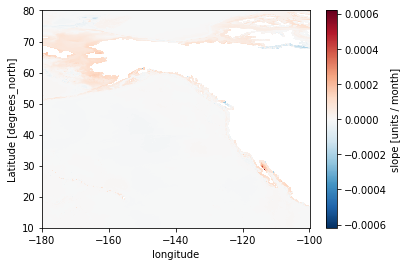

<xarray.DataArray 'detrended_bottomT' (time: 312, latitude: 841, longitude: 961)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 4.39183263e-03,  5.12430810e-03,  5.12427277e-03, ...,
          1.46802748e-03,  2.20047201e-03,  2.93292557e-03],
        [ 2.92700240e

In [49]:
%%time
x=[x for x in range(len(ds.time.values))]
   
#plt.contourf(trend.longitude,trend.latitude,trend.slope)
trend.slope.plot()

plt.show()
y=[(ds.bottomT[i,:,:].values-(trend.slope.values*i + ds.bottomT[0,:,:].values)) for i in x]

# Write to file

data_array=np.zeros((len(ds.time.values),len(trend.latitude),len(trend.longitude)))
for ind,data_at_timestep in enumerate(y):
    data_array[ind,:,:]=data_at_timestep

coords =  {'time': ds.time.values, 'latitude':trend.latitude, 'longitude': trend.longitude}
ds_all=xr.DataArray(name="detrended_bottomT",data=data_array, coords=coords, dims=['time','latitude', 'longitude'])
                        
result_file="../../oceanography/QIN/detrended_bottomT.nc"
if not os.path.exists("ncfiles"): os.mkdir("ncfiles")
            
expanded_da = xr.concat(ds_all, 'time')
expanded_da.to_netcdf(result_file,'w')
print("Detrended data written to {}".format(result_file))

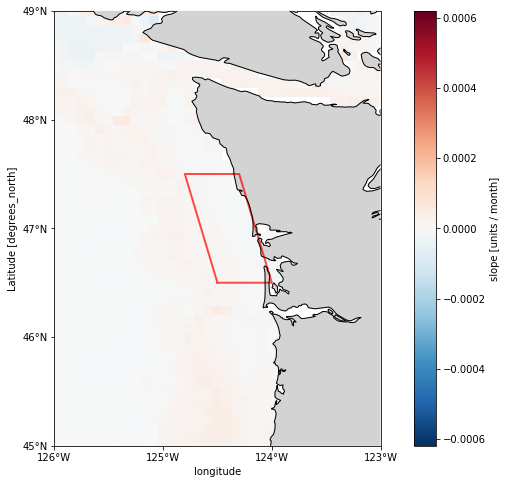

In [50]:
plt.figure(figsize=(12, 8))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
cmap = plt.cm.get_cmap("RdBu_r")
trend.slope.plot(ax=ax, cmap=cmap)
# lmes.plot(ax = ax, alpha = 0.8, facecolor = 'none')
land_10m = cfeature.NaturalEarthFeature("physical", "land", "10m")
ax.add_feature(land_10m, color="lightgrey", edgecolor=None, zorder=4)
ax.coastlines(resolution="10m", linewidth=1, color="black", alpha=1, zorder=5)

ldom = np.array([[45, 49], [-126, -123]])
ax.set_extent([ldom[1, 0], ldom[1, 1], ldom[0, 0], ldom[0, 1]], crs=ccrs.PlateCarree())
ax.set_xticks([*range(ldom[1, 0], ldom[1, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.set_yticks([*range(ldom[0, 0], ldom[0, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=1, alpha=0.5)
qbox = np.array(
    [[-124.5, -124, -124.3, -124.8, -124.5], [46.5, 46.5, 47.5, 47.5, 46.5]]
)
plt.plot(qbox[0, :], qbox[1, :], c="r", lw=2, zorder=5, alpha=0.7)

In [51]:
month_length = xr.DataArray(
    QIN_tools.get_dpm(expanded_da.time.to_index(), calendar="noleap"),
    coords=[ds.time],
    name="month_length",
)

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = (
    month_length.groupby("time.season")
    / month_length.astype(float).groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (expanded_da * weights).groupby("time.season").sum(dim="time")

In [53]:
climatology = expanded_da.groupby("time.month").mean("time", keep_attrs=True)
ds_anomaly = expanded_da.groupby("time.month") - climatology

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Mask region


In [54]:
# Load the shapefile
lme_file = "../data/LME/LME66.shp"
lmes = gpd.read_file(lme_file)
print(lmes.head())

   OBJECTID  LME_NUMBER                 LME_NAME  Shape_Leng  Shape_Area  \
0         1        23.0               Baltic Sea  219.326402   61.950021   
1         2        52.0           Sea of Okhotsk  145.932989  213.796584   
2         3        22.0                North Sea  209.486403  103.965247   
3         4         2.0           Gulf of Alaska  468.695688  203.793868   
4         5         9.0  Labrador - Newfoundland  270.847479  114.597691   

                                            geometry  
0  POLYGON ((10.97944 54.38055, 10.98611 54.37805...  
1  POLYGON ((156.70705 51.18858, 156.62592 51.160...  
2  POLYGON ((5.27889 61.98027, 5.24917 61.97388, ...  
3  POLYGON ((-124.59823 47.90313, -125.85582 47.0...  
4  MULTIPOLYGON (((-64.56793 60.45509, -60.09442 ...  


In [55]:
lmes_mask_poly = regionmask.Regions(
    name="lme_mask",
    numbers=list(range(0, 66)),
    names=list(lmes.LME_NAME),
    abbrevs=list(lmes.LME_NAME),
    outlines=list(lmes.geometry.values[i] for i in range(0, 66)),
)

In [56]:
mask = lmes_mask_poly.mask(
    climatology.sel(latitude=slice(0, 90), longitude=slice(-180, -100)),
    lat_name="latitude",
    lon_name="longitude",
)

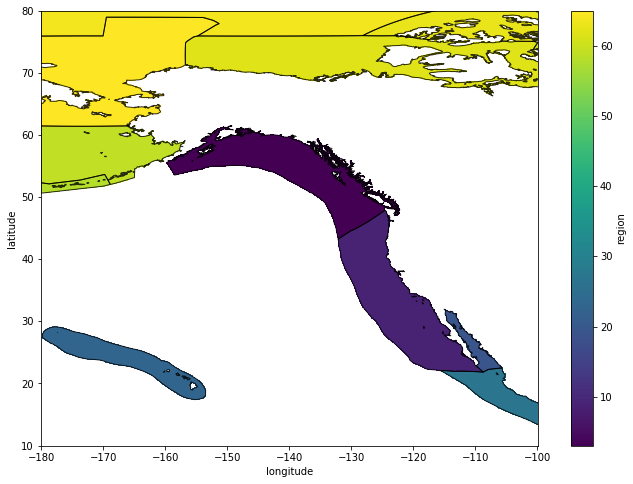

In [57]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
mask.plot(ax=ax)
lmes.plot(ax=ax, alpha=0.8, facecolor="none", lw=1)

In [58]:
def get_lme_id(lme_name):
    LME_REGION = [
        (i, name) for i, name in enumerate(lmes["LME_NAME"]) if name == lme_name
    ]
    print("Mask covers LME {} at index {}".format(LME_REGION[0][1], LME_REGION[0][0]))
    return LME_REGION[0][0]

In [59]:
cal_ID = get_lme_id("California Current")
goa_ID = get_lme_id("Gulf of Alaska")

lat = mask.latitude.values
lon = mask.longitude.values

# [print(i,name) for i,name in enumerate(lmes["LME_NAME"])]

sel_mask = mask.where((mask == cal_ID) | (mask == goa_ID)).values

id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

Mask covers LME California Current at index 9
Mask covers LME Gulf of Alaska at index 3


In [69]:
%%time
def save_climatology(climatology,varname_to_file, varname, depth_index=None):
    
    if varname in ["thetao", "so"]:
        out_selected = climatology[varname].sel(latitude = slice(id_lat[0], id_lat[-1]), longitude = slice(id_lon[0], id_lon[-1])).isel(depth=depth_index).squeeze().compute().where(
    (mask == goa_ID) | (mask == cal_ID))
    else:
        out_selected = climatology[varname].sel(latitude = slice(id_lat[0], id_lat[-1]), longitude = slice(id_lon[0], id_lon[-1])).compute().where(
    (mask == goa_ID) | (mask == cal_ID))
    # Write to file
    coords = {
        "month": out_selected.month.values,
        "latitude": out_selected.latitude.values,
        "longitude": out_selected.longitude.values,
    }
    data_array = xr.DataArray(
        name=varname_to_file,
        data=out_selected,
        coords=coords,
        dims=["month", "latitude", "longitude"],
    )
    result_file = "../../oceanography/QIN/ncfiles/{}_climatology_glorys12v1.nc".format(varname_to_file)
    if not os.path.exists("ncfiles"):
        os.mkdir("ncfiles")
    if os.path.exists(result_file):
        os.remove(result_file)
    data_array.to_netcdf(result_file, "w")
                  
#save_climatology(climatology,"sst", "thetao", 0)
climatology=climatology.to_dataset()
save_climatology(climatology,"detrended_bottomT", "detrended_bottomT")
#save_climatology(climatology,"sss", "so", 0)
#save_climatology(climatology,"bottomS", "so", 49)

<xarray.DataArray 'detrended_bottomT' (month: 12, latitude: 841, longitude: 961)>
array([[[-0.03285862, -0.03124489, -0.03023607, ..., -0.05865406,
         -0.05893251, -0.05878684],
        [-0.0348285 , -0.03237735, -0.03089049, ..., -0.05842995,
         -0.05862227, -0.05901658],
        [-0.03593479, -0.03441656, -0.03222385, ..., -0.0587936 ,
         -0.05899049, -0.05905042],
        ...,
        [-0.10703402, -0.10278983, -0.09653189, ...,  0.30740444,
          0.55091906,  0.60256975],
        [-0.07477485, -0.06161254, -0.05121297, ...,  0.13139874,
          0.05536425, -0.01520687],
        [-0.05994983, -0.05712018, -0.05296746, ...,  0.13198032,
          0.08758522,  0.0386204 ]],

       [[-0.03257962, -0.03057138, -0.02942174, ..., -0.05805945,
         -0.05830956, -0.05830485],
        [-0.03497196, -0.03198558, -0.03021706, ..., -0.05789161,
         -0.05867562, -0.05952065],
        [-0.03610647, -0.03419388, -0.03171951, ..., -0.05952305,
         -0.06025509,

In [ ]:
def get_WOA(varname):

    base_url = "https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o"

    files = ["{}{:02d}_01.nc".format(base_url, month) for month in range(1, 13)]

    print(files)
    d = xr.open_mfdataset(
        files,
        combine="by_coords",decode_times=False,
    )
    print(d)
    ds = d.assign_coords(lon=(((d.lon + 180) % 360) - 180)).sortby(
        "lon"
    )
    print(ds)


get_WOA("oxygen")

In [ ]:
plt.figure(figsize=(12, 8))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
cmap = plt.cm.get_cmap("RdBu_r")
out_sel.bottomT.isel(month=6).plot(ax=ax, cmap=cmap)
# lmes.plot(ax = ax, alpha = 0.8, facecolor = 'none')
land_10m = cfeature.NaturalEarthFeature("physical", "land", "10m")
ax.add_feature(land_10m, color="lightgrey", edgecolor=None, zorder=4)
ax.coastlines(resolution="10m", linewidth=1, color="black", alpha=1, zorder=5)

ldom = np.array([[45, 49], [-126, -123]])
ax.set_extent([ldom[1, 0], ldom[1, 1], ldom[0, 0], ldom[0, 1]], crs=ccrs.PlateCarree())
ax.set_xticks([*range(ldom[1, 0], ldom[1, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.set_yticks([*range(ldom[0, 0], ldom[0, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=1, alpha=0.5)
qbox = np.array(
    [[-124.5, -124, -124.3, -124.8, -124.5], [46.5, 46.5, 47.5, 47.5, 46.5]]
)
plt.plot(qbox[0, :], qbox[1, :], c="r", lw=2, zorder=5, alpha=0.7)

In [ ]:
# get bathymetry from ETOPO1
fname_topo = "../../oceanography/ETOPO1/ETOPO1_Ice_g_gmt4.grd"
ds_topo = xr.open_dataset(fname_topo)
ds_topo.close()
topo = ds_topo.z  # (10801, 21601)
topo2 = topo.sel(y=slice(ldom[0, 0], ldom[0, 1]), x=slice(ldom[1, 0], ldom[1, 1]))
x = topo2.x  # 21601
y = topo2.y  # 10801
X, Y = np.meshgrid(x, y)

In [ ]:
# monthly - climatology
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
# datax,datay=np.meshgrid(ds.lon.values,ds.lat.values)

lev = np.arange(6, 18, 0.5)
fig = plt.figure(figsize=(12, 12), dpi=150)
for i in range(12):

    ax = fig.add_subplot(3, 4, i + 1, projection=ccrs.PlateCarree())
    ax.coastlines(resolution="10m", linewidth=1.5, color="black", alpha=0.8, zorder=4)
    ax.set_extent(
        [ldom[1, 0], ldom[1, 1], ldom[0, 0], ldom[0, 1]], crs=ccrs.PlateCarree()
    )
    ax.set_xticks([*range(ldom[1, 0], ldom[1, 1] + 1, 1)], crs=ccrs.PlateCarree())
    ax.set_yticks([*range(ldom[0, 0], ldom[0, 1] + 1, 1)], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    plt.grid(True, zorder=0, alpha=0.5)
    # ax.set_aspect(1.5)
    plt.contour(
        X,
        Y,
        topo2,
        [-5000, -2000, -1000, -500, -200, -100, -50],
        colors="k",
        linewidths=0.5,
        linestyles="solid",
        zorder=3,
        alpha=0.8,
    )
    # print("Mean for month {} = {}".format(months[i],isel(month = i).mean()))
    print(climatology.thetao.isel(month=i, depth=0).squeeze())
    plt.contourf(
        climatology.longitude,
        climatology.latitude,
        climatology.thetao.isel(month=i, depth=0).squeeze(),
        levels=lev,
        cmap="RdBu_r",
        zorder=2,
        alpha=0.9,
        extend="both",
    )
    plt.colorbar(
        fraction=0.03,
        orientation="horizontal",
        ticks=[*range(int(lev[0]), int(lev[-1]) + 1, 2)],
    )
    plt.plot(qbox[0, :], qbox[1, :], c="r", lw=2, zorder=5, alpha=0.7)
    plt.title(months[i])

# plt.colorbar(fraction=0.06, pad=0.04)
plt.tight_layout(h_pad=1)

plt.savefig("./bottomT_monthly_clim_glorys12v1.png")
plt.show()

In [ ]:
def create_plots(ds2020, ds2050):  # only used for comparisons

    ds_diff = ds2050 - ds2020

    notnull = pd.notnull(ds2050["chl"][0])
    land_110m = cfeature.NaturalEarthFeature("physical", "land", "110m")
    proj = ccrs.PlateCarree()
    extent = [-20, 20, 50, 80]

    fig, axes = plt.subplots(
        nrows=4, ncols=3, figsize=(14, 16), subplot_kw={"projection": proj}
    )
    for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
        ds2020["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 0],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-30, vmax=30, cmap='Spectral_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 0].set_extent(extent, crs=proj)
        axes[i, 0].add_feature(land_110m, color="lightgrey")
        axes[i, 0].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 0].add_feature(cfeature.BORDERS, linestyle=":")

        ds2050["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 1],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-30, vmax=30, cmap='Spectral_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 1].set_extent(extent, crs=proj)
        axes[i, 1].add_feature(land_110m, color="lightgrey")
        axes[i, 1].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 1].add_feature(cfeature.BORDERS, linestyle=":")

        ds_diff["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 2],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-0.1, vmax=.1, cmap='RdBu_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 2].set_extent(extent, crs=proj)
        axes[i, 2].add_feature(land_110m, color="lightgrey")
        axes[i, 2].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 2].add_feature(cfeature.BORDERS, linestyle=":")

        axes[i, 0].set_ylabel(season)
        axes[i, 1].set_ylabel("")
        axes[i, 2].set_ylabel("")

    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")

    axes[0, 0].set_title("ds2020")
    axes[0, 1].set_title("ds2050")
    axes[0, 2].set_title("Difference")

    plt.tight_layout()

    fig.suptitle("Seasonal Chlorophyll", fontsize=16, y=1.02)
    plt.show()

In [ ]:
def season_mean(ds, calendar="standard"):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(
        ds.time.to_index().to_period(freq="Q-NOV").to_timestamp(how="E"),
        coords=[ds.time],
        name="year_season",
    )

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(
        get_dpm(ds.time.to_index(), calendar=calendar),
        coords=[ds.time],
        name="month_length",
    )
    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return np.log((ds * weights).groupby("time.season").sum(dim="time"))